In [2]:
import sys
sys.path.insert(0, '../')

from nn_cno.io.sif import SIF
from nn_cno.io.midas import XMIDAS
from nn_cno.io.cnograph import CNOGraph
from nn_cno.core.base import CNOBase

from nn_cno.core import CNOBase, CNORBase
from nn_cno.core.params import  OptionsBase

from nn_cno.core.results import ODEResults
from nn_cno.core import ReportODE
from nn_cno.core.params import ParamsSSM

# from biokit.rtools import bool2R

from nn_cno.core.params import params_to_update


# `ODE` model


In [3]:
import sys
sys.path.insert(0, '../')
from nn_cno import cnodata, NNODE,CNOBase
# !pip install sympy
import sympy as sym
import networkx as nx
import numpy as np
import scipy.sparse as sp

building the model from SIF and MIDAS

In [4]:
c = NNODE("../nn_cno/datasets/working_case_study/PKN-test.sif",
    "./datasets/working_case_study/MD-test.csv")

Preprocessing: cut non-obserrvable and non-controllable. Right now we dont want expansion. 

In [8]:
c.preprocessing(expansion=False)

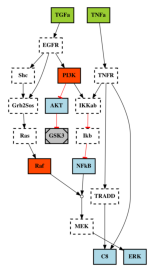

In [9]:
c.plot_pknmodel()

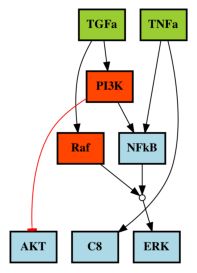

In [10]:
c.plot_model()

In [6]:
states = c._model._get_namesSpecies()
observables = c._model.midas.signals
stimuli = c._model.midas.stimuli
inhibitors = c._model.midas.inhibitors

# building up the tools for ODE modelling

Let's assume we have a parameterized ODE model: 

`dx/dt = f(x,t,k,u)`

we want to solve the equations given some inital values (`x0`), time domain (`t \in [t_0, t_end]`) paramters `k` and input `u`. 
The right hand side `f(x,t,k,u)` is defined based on the PKN and MIDAS files.

I can see multiple options:

1. use PySB under the hood: maybe we could formulate reaction kinetics which could represent the information flow formalism. I think this is not really good, because it is just a workaround. Also I dont think they are compatible with jax.
2. generate the ODE system with Sympy. We could represent the whole ODE right hand side as an array of symbolic expressions, which could be evaluated at any point in the statespace. + there is a library( https://github.com/MilesCranmer/sympy2jax) which connects it to jax . This looks reasonable, but I dont know how much overhead is generated if we need to evaluate the array of  symbolic expressions 1k times for a single simulation. 
3. based on the model (SIF + MIDAS) we generate the adjacency matrix and other utility arrays and then we create a function that builds the right hand side of the ODE every time it is called by looking through the adjacency matrix. (this is the way logicODE is implemented in C). Since this involves only basic arithmetics and for loops, ifs, jax should be compatible with it. 
4. we use Sympy for the the symbolic building of the equation system and then we just write out the symbolic expressions as strings in a function. with string manipulation we make it compatible with jax. We did something similar during my phd: we got the model in MATLAB, then we wrote a  C-file and compiled it before the optimization started. In this case we would write a python file/function. 
5. we learn a new language: D

### Generate the right hand side on the fly

What do we need for the right hand side?
For a given state
- the incoming edges
- the sign of the edge
- boolean relationship of the edges. 

For Avlant's type network we only need the 

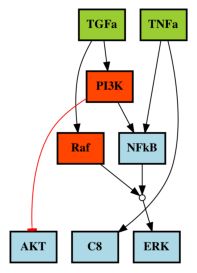

In [11]:
c.plot_model()    

## Hand-written equations

In [12]:
# States
TGFa = sym.symbols("TGFa")
TNFa = sym.symbols("TNFa")
PI3K = sym.symbols("PI3K")
Raf = sym.symbols("Raf")
NFkB = sym.symbols("NFkB")
AKT = sym.symbols("AKT")
C8 = sym.symbols("C8")
ERK = sym.symbols("ERK")

# Tau - one for each state
t_TGFa = sym.symbols("t_TGFa")
t_TNFa = sym.symbols("t_TNFa")
t_PI3K = sym.symbols("t_PI3K")
t_Raf = sym.symbols("t_Raf")
t_NFkB = sym.symbols("t_NFkB")
t_AKT = sym.symbols("t_AKT")
t_C8 = sym.symbols("t_C8")
t_ERK = sym.symbols("t_ERK")

# n and k for each edge
TGFa_k_PI3K = sym.symbols("TGFa_k_PI3K")
TGFa_k_Raf = sym.symbols("TGFa_k_Raf")
TNFa_k_NFkB = sym.symbols("TNFa_k_NFkB")
TNFa_k_C8 = sym.symbols("TNFa_k_C8")
PI3K_k_AKT = sym.symbols("PI3K_k_AKT")
PI3K_k_NFkB = sym.symbols("PI3K_k_NFkB")
Raf_k_ERK = sym.symbols("Raf_k_ERK")
NFkB_k_ERK = sym.symbols("NFkB_k_ERK")

TGFa_n_PI3K = sym.symbols("TGFa_n_PI3K")
TGFa_n_Raf = sym.symbols("TGFa_n_Raf")
TNFa_n_NFkB = sym.symbols("TNFa_n_NFkB")
TNFa_n_C8 = sym.symbols("TNFa_n_C8")
PI3K_n_AKT = sym.symbols("PI3K_n_AKT")
PI3K_n_NFkB = sym.symbols("PI3K_n_NFkB")
Raf_n_ERK = sym.symbols("Raf_n_ERK")
NFkB_n_ERK = sym.symbols("NFkB_n_ERK")

# state names: 
sym_states = [TGFa, TNFa, PI3K, Raf, NFkB,AKT,C8,ERK]
state_names = ["TGFa", "TNFa", "PI3K", "Raf", "NFkB","AKT","C8","ERK"]
# parameter names: tau, n and k parameters
parameter_names = [ ["t_TGFa", "t_TNFa", "t_PI3K", "t_Raf", "t_NFkB","t_AKT","t_C8","t_ERK"],
                    ["TGFa_n_PI3K", "TGFa_n_Raf", "TNFa_n_NFkB", "TNFa_n_C8","PI3K_n_AKT","PI3K_n_NFkB","Raf_n_ERK","NFkB_n_ERK"],
                    ["TGFa_k_PI3K", "TGFa_k_Raf", "TNFa_k_NFkB", "TNFa_k_C8","PI3K_k_AKT","PI3K_k_NFkB","Raf_k_ERK","NFkB_k_ERK"]
                    ]

sym_parmeters =  [ t_TGFa, t_TNFa, t_PI3K, t_Raf, t_NFkB,t_AKT,t_C8,t_ERK,
                    TGFa_n_PI3K, TGFa_n_Raf, TNFa_n_NFkB, TNFa_n_C8,PI3K_n_AKT,PI3K_n_NFkB,Raf_n_ERK,NFkB_n_ERK,
                    TGFa_k_PI3K, TGFa_k_Raf, TNFa_k_NFkB, TNFa_k_C8,PI3K_k_AKT,PI3K_k_NFkB,Raf_k_ERK,NFkB_k_ERK
                    ]               


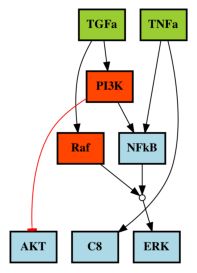

In [13]:
c.plot_model()

In [17]:
# normalised Hill equations (for each reactions) ( x^n / (k^n + x^n) * {1/(1/k^n + 1)} )
def norm_hill_fun(parental_var,n,k):
    return parental_var**n / (k**n + parental_var**n) * (k**n + 1)

def ORgate(x,y):
    return x+y-x*y 
    
def ANDgate(x,y):
    return x*y 

In [83]:
def get_sym_right_hand_side(iEXP = 0):
    # right hand sides
    f_TGFa = 0
    f_TNFa = 0

    if inhibitors["PI3K"][iEXP] == 1:
        f_PI3K = PI3K - PI3K  # 0, but symbolic:D
    else:
        f_PI3K = t_PI3K*(norm_hill_fun(TGFa,TGFa_n_PI3K,TGFa_k_PI3K) - PI3K)

    if inhibitors["Raf"][iEXP] == 1:
        f_Raf = Raf - Raf
    else:
        f_Raf = t_Raf*(norm_hill_fun(TGFa,TGFa_n_Raf,TGFa_k_Raf) - Raf)

    f_NFkB = t_NFkB*(ORgate(norm_hill_fun(PI3K,PI3K_n_NFkB,PI3K_k_NFkB),norm_hill_fun(TNFa,TNFa_n_NFkB,TNFa_k_NFkB)) - NFkB )
        
    f_AKT = t_AKT*(1-norm_hill_fun(PI3K,PI3K_n_AKT,PI3K_k_AKT) - AKT)
    f_C8 = t_C8 * (norm_hill_fun(TNFa,TNFa_n_C8,TNFa_k_C8) - C8)
    f_ERK = t_ERK * (ANDgate(norm_hill_fun(Raf,Raf_n_ERK,Raf_k_ERK),norm_hill_fun(NFkB,NFkB_n_ERK,NFkB_k_ERK)) - ERK)

    return [f_TGFa,f_TNFa,f_PI3K,f_Raf,f_NFkB,f_AKT,f_C8,f_ERK]

In [84]:
iexp  =0
f_sym = get_sym_right_hand_side(iEXP=iexp)
f_sym

[0,
 0,
 t_PI3K*(-PI3K + TGFa**TGFa_n_PI3K*(TGFa_k_PI3K**TGFa_n_PI3K + 1)/(TGFa**TGFa_n_PI3K + TGFa_k_PI3K**TGFa_n_PI3K)),
 t_Raf*(-Raf + TGFa**TGFa_n_Raf*(TGFa_k_Raf**TGFa_n_Raf + 1)/(TGFa**TGFa_n_Raf + TGFa_k_Raf**TGFa_n_Raf)),
 t_NFkB*(-NFkB - PI3K**PI3K_n_NFkB*TNFa**TNFa_n_NFkB*(PI3K_k_NFkB**PI3K_n_NFkB + 1)*(TNFa_k_NFkB**TNFa_n_NFkB + 1)/((PI3K**PI3K_n_NFkB + PI3K_k_NFkB**PI3K_n_NFkB)*(TNFa**TNFa_n_NFkB + TNFa_k_NFkB**TNFa_n_NFkB)) + PI3K**PI3K_n_NFkB*(PI3K_k_NFkB**PI3K_n_NFkB + 1)/(PI3K**PI3K_n_NFkB + PI3K_k_NFkB**PI3K_n_NFkB) + TNFa**TNFa_n_NFkB*(TNFa_k_NFkB**TNFa_n_NFkB + 1)/(TNFa**TNFa_n_NFkB + TNFa_k_NFkB**TNFa_n_NFkB)),
 t_AKT*(-AKT - PI3K**PI3K_n_AKT*(PI3K_k_AKT**PI3K_n_AKT + 1)/(PI3K**PI3K_n_AKT + PI3K_k_AKT**PI3K_n_AKT) + 1),
 t_C8*(-C8 + TNFa**TNFa_n_C8*(TNFa_k_C8**TNFa_n_C8 + 1)/(TNFa**TNFa_n_C8 + TNFa_k_C8**TNFa_n_C8)),
 t_ERK*(-ERK + NFkB**NFkB_n_ERK*Raf**Raf_n_ERK*(NFkB_k_ERK**NFkB_n_ERK + 1)*(Raf_k_ERK**Raf_n_ERK + 1)/((NFkB**NFkB_n_ERK + NFkB_k_ERK**NFkB_n_ERK)*(Ra

## Evaluate the equation at a random point in statespace and paraemeter

In [64]:
from random import seed
from random import random

In [85]:
# generate random numbers for the parameters

tau_parameter_value = [random() for _ in range(len(parameter_names[0]))]
k_parameter_value = [random()*5 for _ in range(len(parameter_names[1]))]
n_parameter_value = [1+random() for _ in range(len(parameter_names[2]))]

parameter_values = [*tau_parameter_value,*n_parameter_value,*k_parameter_value]

# generate state vector
states_value = [random() for _ in range(len(state_names))]


In [86]:
# to evaluate the symbolic expression, we need to create dictionaries with symbols and points
parameter_names_flat = [parameter for parameter_type in parameter_names for parameter in parameter_type ]
parameters = dict(zip(parameter_names_flat, parameter_values))
parameters

statespace = dict(zip(state_names, states_value))

all_vars = dict(parameters,**statespace)
all_vars

{'t_TGFa': 0.24806870247310475,
 't_TNFa': 0.019819464029554368,
 't_PI3K': 0.049078483044040166,
 't_Raf': 0.745558396321735,
 't_NFkB': 0.8244180836179712,
 't_AKT': 0.8735909907184092,
 't_C8': 0.5242222393442514,
 't_ERK': 0.4945263755878635,
 'TGFa_n_PI3K': 1.3889621131031504,
 'TGFa_n_Raf': 1.6004410512118814,
 'TNFa_n_NFkB': 1.7721449227350559,
 'TNFa_n_C8': 1.7151400466069369,
 'PI3K_n_AKT': 1.0650959821510289,
 'PI3K_n_NFkB': 1.240793718942087,
 'Raf_n_ERK': 1.3881565509287674,
 'NFkB_n_ERK': 1.7383889916035853,
 'TGFa_k_PI3K': 0.30926590205655746,
 'TGFa_k_Raf': 1.4890436554021251,
 'TNFa_k_NFkB': 4.760775129514723,
 'TNFa_k_C8': 4.77715842973746,
 'PI3K_k_AKT': 2.5595953299882557,
 'PI3K_k_NFkB': 2.257955966363554,
 'Raf_k_ERK': 2.8475045442321205,
 'NFkB_k_ERK': 4.442811434974275,
 'TGFa': 0.6127126572370717,
 'TNFa': 0.5897872491602009,
 'PI3K': 0.9375332576741583,
 'Raf': 0.6324703027030472,
 'NFkB': 0.30133556581681553,
 'AKT': 0.8458070318878126,
 'C8': 0.11711080383588

In [130]:
f_num = list()
for f in f_sym:
    if f==0:
        f_num.append(0)
    else:
        f_num.append(f.evalf(subs=all_vars))
f_num

[0,
 0,
 -0.00369184752579601,
 -0.0523439097751542,
 0.547844533359376,
 -0.695704142477518,
 0.158959070272520,
 -0.238889422103093]

In [35]:
states = c._model._get_namesSpecies()
observables = c._model.midas.signals
stimuli = c._model.midas.stimuli
inhibitors = c._model.midas.inhibitors
print(stimuli)

              TGFa  TNFa
experiment_0     1     0
experiment_1     0     1
experiment_2     1     1
experiment_3     1     0
experiment_4     1     1
experiment_5     1     0


## Use Sympy2jax

In [90]:
# !pip install git+https://github.com/MilesCranmer/sympy2jax.git

In [67]:
import jax
import jax.numpy as jnp
from jax import random as jxrandom
from sympy2jax import sympy2jax

In [107]:
f_sym

[0,
 0,
 t_PI3K*(-PI3K + TGFa**TGFa_n_PI3K*(TGFa_k_PI3K**TGFa_n_PI3K + 1)/(TGFa**TGFa_n_PI3K + TGFa_k_PI3K**TGFa_n_PI3K)),
 t_Raf*(-Raf + TGFa**TGFa_n_Raf*(TGFa_k_Raf**TGFa_n_Raf + 1)/(TGFa**TGFa_n_Raf + TGFa_k_Raf**TGFa_n_Raf)),
 t_NFkB*(-NFkB - PI3K**PI3K_n_NFkB*TNFa**TNFa_n_NFkB*(PI3K_k_NFkB**PI3K_n_NFkB + 1)*(TNFa_k_NFkB**TNFa_n_NFkB + 1)/((PI3K**PI3K_n_NFkB + PI3K_k_NFkB**PI3K_n_NFkB)*(TNFa**TNFa_n_NFkB + TNFa_k_NFkB**TNFa_n_NFkB)) + PI3K**PI3K_n_NFkB*(PI3K_k_NFkB**PI3K_n_NFkB + 1)/(PI3K**PI3K_n_NFkB + PI3K_k_NFkB**PI3K_n_NFkB) + TNFa**TNFa_n_NFkB*(TNFa_k_NFkB**TNFa_n_NFkB + 1)/(TNFa**TNFa_n_NFkB + TNFa_k_NFkB**TNFa_n_NFkB)),
 t_AKT*(-AKT - PI3K**PI3K_n_AKT*(PI3K_k_AKT**PI3K_n_AKT + 1)/(PI3K**PI3K_n_AKT + PI3K_k_AKT**PI3K_n_AKT) + 1),
 t_C8*(-C8 + TNFa**TNFa_n_C8*(TNFa_k_C8**TNFa_n_C8 + 1)/(TNFa**TNFa_n_C8 + TNFa_k_C8**TNFa_n_C8)),
 t_ERK*(-ERK + NFkB**NFkB_n_ERK*Raf**Raf_n_ERK*(NFkB_k_ERK**NFkB_n_ERK + 1)*(Raf_k_ERK**Raf_n_ERK + 1)/((NFkB**NFkB_n_ERK + NFkB_k_ERK**NFkB_n_ERK)*(Ra

In [108]:
all_syms = [*sym_states, *sym_parmeters]
f, params = sympy2jax(f_sym[2], all_syms)
[f,params]

[<function sympy2jax.sympy2jax.A_6581646506665418780(X, parameters)>,
 DeviceArray([], dtype=float32)]

In [184]:
all_syms = [*sym_states, *sym_parmeters]

# Construct a list of jax functions. 
f_jax = list()
f_jax_params = list()
for i_f_sym in f_sym:
    if i_f_sym==0:
        f_jax.append(0)
        f_jax_params.append(0)
    else:
        f, params = sympy2jax(i_f_sym, all_syms)
        f_jax.append(jax.jit(f))
        f_jax_params.append(params)
        

f_jax

#f, params = sympy2jax(eq3, all_syms)

[0,
 0,
 <CompiledFunction of <function A_6581646506665418780 at 0x17f942830>>,
 <CompiledFunction of <function A_7172271921439507574 at 0x17f870550>>,
 <CompiledFunction of <function A_7146026473014885935 at 0x17f943880>>,
 <CompiledFunction of <function A_6531080637716055163 at 0x17f9c01f0>>,
 <CompiledFunction of <function A_7863004282203829784 at 0x17f9c0790>>,
 <CompiledFunction of <function A_952042363320530601 at 0x17f9c0d30>>]

In [201]:
myargs = [f_jax, f_jax_params, parameter_values]

def nice_ode(t, y, args):

    # get my data: 
    f_jax = args[0]
    f_jax_p = args[1]
    parameter_vals = args[2]

    jax_pars = [*y,*parameter_vals]
    fy = list()

    for i in range(len(y)):
        if f_jax[i] == 0:
            fy.append(jnp.array([0.0,])[0])
        else:
            fy.append(f_jax[i](jnp.array([jax_pars,]),f_jax_p[1])[0])
    return jnp.asarray(fy)

In [202]:
# test the right hand side function
y = np.array(list(statespace.values()))
nice_ode(0,y,myargs)



DeviceArray([ 0.        ,  0.        , -0.00369185, -0.05234392,
              0.5478445 , -0.69570416,  0.15895906, -0.23888944],            dtype=float32)

In [172]:
from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt
import jax.numpy as jnp

In [155]:
y0.transpose()

DeviceArray([1., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [187]:
ts = jnp.linspace(0, 10, 100)


term = ODETerm(nice_ode)
solver = Dopri5()
y0 = jnp.array([1., 1., 0., 0., 0., 0., 0., 0.])
solution = diffeqsolve(term, solver, t0=0, t1=10, dt0=0.1, y0=y0, args = myargs,saveat=SaveAt(ts=ts))

In [166]:
import matplotlib.pyplot as plt

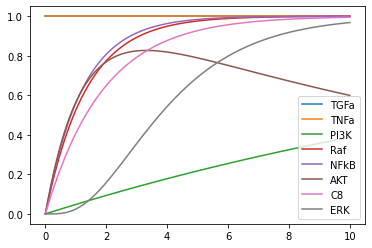

In [188]:
ts = solution.ts
ys = solution.ys

for istate in range(len(state_names)):
    plt.plot(ts, ys[:, istate],label=state_names[istate])
plt.legend()
plt.show()
    

# Clean up the code


dependencies:

In [323]:
#!pip install optax

In [1]:
# basics
import numpy.random as npr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# symbolic computation:
import sympy as sym
from sympy2jax import sympy2jax

# jax: 
import jax
import jax.numpy as jnp
from jax import random as jxrandom
import jax.numpy as jnp

# ODE solution Diffrax: 
from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt
import diffrax

# optimization:
import optax

definition of the ToyMSB model using `sympy`  
TODOs:
- vectorize (state-vector, parameter vector etc)
- generate the equations from the reaction graph
- extend the AND and OR gates to multiple inputs


In [2]:
# States
TGFa = sym.symbols("TGFa")
TNFa = sym.symbols("TNFa")
PI3K = sym.symbols("PI3K")
Raf = sym.symbols("Raf")
NFkB = sym.symbols("NFkB")
AKT = sym.symbols("AKT")
C8 = sym.symbols("C8")
ERK = sym.symbols("ERK")

# Tau - one for each state
t_TGFa = sym.symbols("t_TGFa")
t_TNFa = sym.symbols("t_TNFa")
t_PI3K = sym.symbols("t_PI3K")
t_Raf = sym.symbols("t_Raf")
t_NFkB = sym.symbols("t_NFkB")
t_AKT = sym.symbols("t_AKT")
t_C8 = sym.symbols("t_C8")
t_ERK = sym.symbols("t_ERK")

# n and k for each edge
TGFa_k_PI3K = sym.symbols("TGFa_k_PI3K")
TGFa_k_Raf = sym.symbols("TGFa_k_Raf")
TNFa_k_NFkB = sym.symbols("TNFa_k_NFkB")
TNFa_k_C8 = sym.symbols("TNFa_k_C8")
PI3K_k_AKT = sym.symbols("PI3K_k_AKT")
PI3K_k_NFkB = sym.symbols("PI3K_k_NFkB")
Raf_k_ERK = sym.symbols("Raf_k_ERK")
NFkB_k_ERK = sym.symbols("NFkB_k_ERK")

TGFa_n_PI3K = sym.symbols("TGFa_n_PI3K")
TGFa_n_Raf = sym.symbols("TGFa_n_Raf")
TNFa_n_NFkB = sym.symbols("TNFa_n_NFkB")
TNFa_n_C8 = sym.symbols("TNFa_n_C8")
PI3K_n_AKT = sym.symbols("PI3K_n_AKT")
PI3K_n_NFkB = sym.symbols("PI3K_n_NFkB")
Raf_n_ERK = sym.symbols("Raf_n_ERK")
NFkB_n_ERK = sym.symbols("NFkB_n_ERK")

# state names: 
sym_states = [TGFa, TNFa, PI3K, Raf, NFkB,AKT,C8,ERK]
state_names = ["TGFa", "TNFa", "PI3K", "Raf", "NFkB","AKT","C8","ERK"]
# parameter names: tau, n and k parameters
parameter_names = [["t_TGFa", "t_TNFa", "t_PI3K", "t_Raf", "t_NFkB","t_AKT","t_C8","t_ERK"],
                    ["TGFa_n_PI3K", "TGFa_n_Raf", "TNFa_n_NFkB", "TNFa_n_C8","PI3K_n_AKT","PI3K_n_NFkB","Raf_n_ERK","NFkB_n_ERK"],
                    ["TGFa_k_PI3K", "TGFa_k_Raf", "TNFa_k_NFkB", "TNFa_k_C8","PI3K_k_AKT","PI3K_k_NFkB","Raf_k_ERK","NFkB_k_ERK"]]

sym_parmeters =  [t_TGFa, t_TNFa, t_PI3K, t_Raf, t_NFkB,t_AKT,t_C8,t_ERK,
                    TGFa_n_PI3K, TGFa_n_Raf, TNFa_n_NFkB, TNFa_n_C8,PI3K_n_AKT,PI3K_n_NFkB,Raf_n_ERK,NFkB_n_ERK,
                    TGFa_k_PI3K, TGFa_k_Raf, TNFa_k_NFkB, TNFa_k_C8,PI3K_k_AKT,PI3K_k_NFkB,Raf_k_ERK,NFkB_k_ERK]   

#Experiment design:
inhibitors = pd.DataFrame(
    {
        'PI3K': [0, 0, 0, 1, 1, 0],
        'Raf': [0, 0, 0, 0, 0, 1]
    }, 
    index = [f"experiment_{i}" for i in range(6)])
    
# normalised Hill equations (for each reactions) ( x^n / (k^n + x^n) * {1/(1/k^n + 1)} )
def norm_hill_fun(parental_var,n,k):
    return parental_var**n / (k**n + parental_var**n) * (k**n + 1)

def ORgate(x,y):
    return x+y-x*y 
    
def ANDgate(x,y):
    return x*y 

def get_sym_right_hand_side(iEXP = 0):
    # right hand sides
    f_TGFa = 0
    f_TNFa = 0

    if inhibitors["PI3K"][iEXP] == 1:
        f_PI3K = PI3K - PI3K  # 0, but symbolic:D
    else:
        f_PI3K = t_PI3K*(norm_hill_fun(TGFa,TGFa_n_PI3K,TGFa_k_PI3K) - PI3K)

    if inhibitors["Raf"][iEXP] == 1:
        f_Raf = Raf - Raf
    else:
        f_Raf = t_Raf*(norm_hill_fun(TGFa,TGFa_n_Raf,TGFa_k_Raf) - Raf)

    f_NFkB = t_NFkB*(ORgate(norm_hill_fun(PI3K,PI3K_n_NFkB,PI3K_k_NFkB),norm_hill_fun(TNFa,TNFa_n_NFkB,TNFa_k_NFkB)) - NFkB )
        
    f_AKT = t_AKT*(1-norm_hill_fun(PI3K,PI3K_n_AKT,PI3K_k_AKT) - AKT)
    f_C8 = t_C8 * (norm_hill_fun(TNFa,TNFa_n_C8,TNFa_k_C8) - C8)
    f_ERK = t_ERK * (ANDgate(norm_hill_fun(Raf,Raf_n_ERK,Raf_k_ERK),norm_hill_fun(NFkB,NFkB_n_ERK,NFkB_k_ERK)) - ERK)

    return [f_TGFa,f_TNFa,f_PI3K,f_Raf,f_NFkB,f_AKT,f_C8,f_ERK]

iexp =0

# get the symbolic equation of the ODE's right hand side
f_sym = get_sym_right_hand_side(iEXP=iexp)

Numerical parameter values

In [3]:
# generate random numbers for the different types of parameters

def generate_random_parameters(key,par_names):
    key_tau, key_k, key_n  = jax.random.split(key,3)
    tau_parameter_value = jax.random.uniform(key_tau,shape=(len(par_names[0]),),minval=1e-5,maxval=1)
    k_parameter_value = jax.random.uniform(key_k,shape=(len(par_names[1]),),minval=0.5,maxval=5)
    n_parameter_value = jax.random.uniform(key_n,shape=(len(par_names[2]),),minval=1,maxval=3)

    parameter_values = jnp.concatenate((tau_parameter_value,n_parameter_value,k_parameter_value))
    return(parameter_values)

par_key = jax.random.PRNGKey(1246)
parameter_values =  generate_random_parameters(key=par_key,par_names=parameter_names)

Convert the symbolic ODEs to `jax` expressions

In [4]:
all_syms = [*sym_states, *sym_parmeters]

# vectorized version of sympy2jax. Converts the list of equations into a list of `jax` and `param` objects
def symODEs2jax(f_sym):

    # Construct a list of jax functions. 
    f_jax = list()
    f_jax_params = list()
    for i_f_sym in f_sym:
        if i_f_sym==0:
            f_jax.append(0)
            f_jax_params.append(0)
        else:
            f, params = sympy2jax(i_f_sym, all_syms)
            f_jax.append(f)
            f_jax_params.append(params)
    return   f_jax, f_jax_params

f_jax, f_jax_params = symODEs2jax(f_sym)

Formulate the ODE function that takes the state vector (`y`), time (`t`) and users' data (`args`) and returns the evaluation of the right hand side


In [5]:
def jaxODE2numeric(t, y, args):

    # get users data containinf the jax objects and model parameters: 
    f_jax = args["jax_eqns"]
    f_jax_p = args["jax_parameters"]
    parameter_vals = args["model_parameters"]

    jax_pars = [*y,*parameter_vals]
    fy = list()

    for i in range(len(y)):
        if f_jax[i] == 0:
            fy.append(jnp.array([0.0,])[0])
        else:
            fy.append(f_jax[i](jnp.array([jax_pars,]),f_jax_p[1])[0])
    return jnp.asarray(fy)

Solve the ODE using `diffrax`

In [6]:
model_data = {"jax_eqns" : f_jax,
         "jax_parameters": f_jax_params,
         "model_parameters": parameter_values}

def simulate_model(model_data, ts = jnp.linspace(0, 10, 100), y0= jnp.array([1., 1., 0., 0., 0., 0., 0., 0.])):

    
    term = ODETerm(jaxODE2numeric)

    # ODE solvers based on the recommendation from  https://docs.kidger.site/diffrax/usage/how-to-choose-a-solver/
    # 
    # Non-stiff solver:
    # diffrax.Heun - low accuracy, but could be useful for neural ODEs
    # diffrax.Tsit5 - good general purpose solver, slightly better than Dopri5
    # 
    # Stiff solver: 
    # Kvaerno3, Kvaerno4, Kvaerno5  
    # use adaptive step size controller PIDController

    solver = diffrax.Heun()
    solution = diffeqsolve(term, solver, t0=ts[0], t1=ts[-1], dt0=0.1, y0=y0, args = model_data, 
                saveat=SaveAt(ts=ts),stepsize_controller = diffrax.PIDController(atol=1e-3,rtol=1e-3))

    return solution.ts, solution.ys

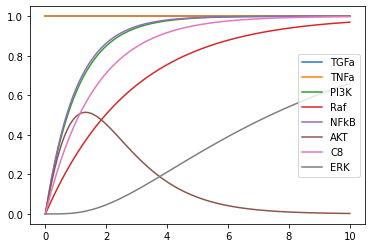

In [7]:
sol_ts, sol_ys = simulate_model(model_data)

def plot_simulation(ts,ys,names):

    for istate in range(len(names)):
        plt.plot(ts, ys[:, istate],label=names[istate])
    plt.legend()
    plt.show()
plot_simulation(sol_ts,sol_ys,state_names)

## Model optimization

generate training data

In [8]:
def get_simulated_data(N_ts, key, model_data, noise_sd):

    ts = jnp.linspace(0, 10, N_ts)
    sol_ts, sol_ys = simulate_model(model_data, ts = jnp.linspace(0, 10, N_ts))

    ys = sol_ys
    ys += noise_sd*jxrandom.normal(key,(ys.shape[0],ys.shape[1]))
    ys = abs(ys)
    return sol_ts, ys

In [9]:
# random key to generate the ground truth data: 
key_GT = jax.random.PRNGKey(5678)
par_key, noise_key = jxrandom.split(key_GT,2)

# parameter values in the GT model:
GT_parameter_values =  generate_random_parameters(key=par_key,par_names=parameter_names)
gt_model = model_data
gt_model['model_parameters'] = GT_parameter_values

#Exp design: take 5 samples across time: 
N_samples = 5

training_data = get_simulated_data(N_samples, key=noise_key, model_data = gt_model, noise_sd=0.05)
training_data_no_noise = get_simulated_data(N_samples, key=noise_key, model_data = gt_model, noise_sd=0)

plotting training data

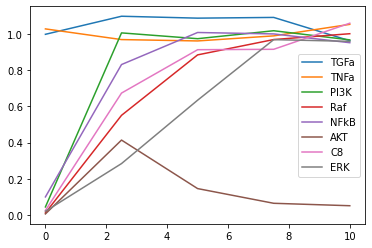

In [10]:
plot_simulation( ts=training_data[0],ys=training_data[1],names=state_names)

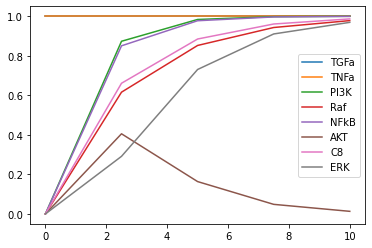

In [11]:
plot_simulation( ts=training_data_no_noise[0],ys=training_data_no_noise[1],names=state_names)

In [12]:
# mean squared error calculation. Copied from Pablo. Not sure if we need nan or if it is correctly handled for ODEs. 
# FIXME handle cases when nans are in the data or simulation

def loss_mse(X,X_hat):
    # Count the number of valid values in the matrix
    is_nan = jnp.isnan(X)
    n = jnp.sum(~is_nan)
    # Replace NaNs with 0s. It does not affect the loss
    # as we're going to compute the average ignoring 0s
    Xf = jnp.nan_to_num(X, nan=0.)
    # Put 0s on NaN positions
    X_hat_f = jnp.where(is_nan, 0., X_hat)
    # Sum of squared residuals
    sq = jnp.power(Xf - X_hat_f, 2)
    # Average using non missing entries
    return jnp.sum(sq) / n


loss_mse(training_data[1],training_data_no_noise[1])

DeviceArray(0.00245088, dtype=float32)

In [13]:
working_model_data = model_data.copy()

# Loss function called by the optimizer. 
# simulates the model and returns the objective function value. 
def loss(params:optax.Params, y:jnp.ndarray) -> jnp.ndarray:
    working_model_data["model_parameters"] = params
    
    _, y_hat = simulate_model(ts=jnp.linspace(0, 10, N_samples), model_data=working_model_data)
    #print(y_hat)
    return loss_mse(y,y_hat)


In [14]:
# test: ground truth parameter vs noise-free training data: 
print(loss(GT_parameter_values,training_data_no_noise[1]))

# test 2: ground truth parameters vs noisy data
print(loss(GT_parameter_values,training_data[1]))

# test 3: perturbed parameters vs noise free data
perturbed_pars = GT_parameter_values + 0.1*jxrandom.normal(jax.random.PRNGKey(1),(GT_parameter_values.shape[0],))
print(loss(perturbed_pars,training_data_no_noise[1]))

0.0
0.002450878
0.00275029


In [15]:
# Initial parameters for the optimization. 
# Make sure it is different from the ground truth :) 
# Also make sure the initial cost is worse than the simulation with the ground truth parameter vector

key_optim_init_par = jax.random.PRNGKey(197)
initial_params =  generate_random_parameters(key=key_optim_init_par,par_names=parameter_names)
print("difference from the ground truth parameters:")
print(initial_params - GT_parameter_values)
print("loss with the initial parameters:")
print("\t" + str(loss(initial_params,training_data[1])))
print("loss with the ground truth parameters:")
print("\t" + str(loss(GT_parameter_values,training_data[1])))

difference from the ground truth parameters:
[-2.6584238e-01 -5.0790966e-02 -5.0273609e-01 -1.5214792e-01
  1.3970900e-01  2.6006770e-01 -4.1763210e-01 -4.8793173e-01
  3.1356645e-01 -5.3030014e-01  1.4325817e+00  5.0519371e-01
 -9.8922467e-01  2.6668882e-01  1.3079793e+00 -1.3101101e-03
 -2.0347238e-01 -1.5911324e+00  9.7999072e-01 -3.1753933e+00
 -1.1988883e+00 -6.4866185e-01  1.2459474e+00 -2.0891743e+00]
loss with the initial parameters:
	0.089982614
loss with the ground truth parameters:
	0.002450878


Compute the finite difference based grad of the loss function to see if jax returns the correct value

In [16]:
loss(initial_params,training_data[1])
ref = initial_params.copy()
loss(ref,training_data[1])


DeviceArray(0.08998261, dtype=float32)

In [17]:
# computes the gradient by central finite difference
# evaluates the loss function at p and measured_data
def cfd_grad_loss(p,measured_data,dp=0.01):
    
    ref = p.copy()

    grad = np.zeros((len(p),))

    for i in range(len(p)):
        p_working_p = np.array(ref)
        p_working_n = np.array(ref)
        p_working_p[i] += dp/2
        p_working_n[i] -= dp/2
        forward = loss(jnp.array(p_working_p),measured_data)
        backward = loss(jnp.array(p_working_n),measured_data)
        grad[i] = (forward - backward) / (dp)
    return(grad)

cfd_grad_loss(initial_params,training_data[1])

array([ 0.00000000e+00,  0.00000000e+00, -5.29475510e-02, -1.54880434e-01,
       -7.89761543e-05, -4.40329313e-04, -9.34488356e-01, -2.16804445e-02,
       -1.49011612e-06,  1.49011612e-06,  0.00000000e+00,  0.00000000e+00,
        3.94135714e-03, -7.45058060e-07,  8.59797001e-03,  7.22706318e-05,
        7.45058060e-07,  7.45058060e-07, -7.45058060e-07,  0.00000000e+00,
        4.74601984e-04,  1.49011612e-06,  3.30805779e-04,  5.08874655e-04])

In [18]:
optimizer = optax.adam(learning_rate=1e-2) 
opt_state = optimizer.init(initial_params)
params = initial_params

loss_value, grads = jax.value_and_grad(loss)(params, training_data[1])


In [19]:
loss_value

DeviceArray(0.08998264, dtype=float32)

In [20]:
grads

DeviceArray([ 0.0000000e+00,  0.0000000e+00, -5.2929558e-02,
             -1.5482330e-01, -7.1480135e-05, -4.3470750e-04,
             -9.3349218e-01, -2.1679381e-02, -2.8467184e-10,
              2.9831426e-09, -3.9398174e-10,  7.6397555e-11,
              3.9425925e-03, -7.1305684e-11,  8.5970582e-03,
              7.2868002e-05, -2.4811015e-09,  2.1973392e-09,
             -1.2789769e-10,  2.1100277e-10,  4.7517344e-04,
             -4.5117785e-11,  3.3132813e-04,  5.0829642e-04],            dtype=float32)

In [21]:
def fit(params: optax.Params, optimizer: optax.GradientTransformation) -> optax.Params:
  opt_state = optimizer.init(params)

  def step(params, opt_state, training_data_batch):
    loss_value, grads = jax.value_and_grad(loss)(params, training_data_batch)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

  for i in range(500):
    data  = training_data[1]
    params, opt_state, loss_value = step(params, opt_state, data)
    if i % 10 == 0:
      print(f'step {i}, loss: {loss_value}')

  return params

# Finally, we can fit our parametrized function using the Adam optimizer
# provided by optax.
optimizer = optax.adam(learning_rate=1e-2)
params = fit(initial_params, optimizer)

step 0, loss: 0.08998263627290726
step 10, loss: 0.028022151440382004
step 20, loss: 0.012836119160056114
step 30, loss: 0.00826035626232624
step 40, loss: 0.006450826767832041
step 50, loss: 0.0055086310021579266
step 60, loss: 0.004902943037450314
step 70, loss: 0.004460158292204142
step 80, loss: 0.0041143507696688175
step 90, loss: 0.003838446456938982
step 100, loss: 0.0036143746692687273
step 110, loss: 0.0034284249413758516
step 120, loss: 0.003271767171099782
step 130, loss: 0.0031384299509227276
step 140, loss: 0.003024174366146326
step 150, loss: 0.00292575778439641
step 160, loss: 0.0028406656347215176
step 170, loss: 0.0027668545953929424
step 180, loss: 0.002702620578929782
step 190, loss: 0.00264656450599432
step 200, loss: 0.002597569487988949
step 210, loss: 0.002554647158831358
step 220, loss: 0.0025169544387608767
step 230, loss: 0.0024837241508066654
step 240, loss: 0.0024543723557144403
step 250, loss: 0.002428351668640971
step 260, loss: 0.0024051994550973177
step 

# Automatic equation generation

In [22]:
import sys
sys.path.insert(0, '../')
from nn_cno import NNODE

In [23]:

c = NNODE("../nn_cno/datasets/working_case_study/PKN-test.sif",
    "./datasets/working_case_study/MD-test.csv")
c.preprocessing(expansion=False)

In [24]:
c._model.species

['AKT', 'C8', 'ERK', 'NFkB', 'PI3K', 'Raf', 'TGFa', 'TNFa']

In [25]:
# States
states = c._model.species
sym_states = sym.symbols(states)
sym_tau = sym.symbols(["tau_"+s for s in states])

reactions = c._model.reactions

In [26]:
[c._model.reac2edges(r) for r in reactions]

[[('PI3K', 'AKT', '-')],
 [('NFkB', 'NFkB^Raf=ERK', '+'),
  ('Raf', 'NFkB^Raf=ERK', '+'),
  ('NFkB^Raf=ERK', 'ERK')],
 [('PI3K', 'NFkB', '+')],
 [('TGFa', 'PI3K', '+')],
 [('TGFa', 'Raf', '+')],
 [('TNFa', 'C8', '+')],
 [('TNFa', 'NFkB', '+')]]

In [27]:
# normalised Hill equations (for each reactions) ( x^n / (k^n + x^n) * {1/(1/k^n + 1)} )
def norm_hill_fun(parental_var,n,k):
    return parental_var**n / (k**n + parental_var**n) * (k**n + 1)

def ORgate(x,y):
    return x+y-x*y 
    
def ANDgate(x,y):
    return x*y 

In [29]:
def simple_reaction_to_sym(node,pred,sign):
    par_k = sym.symbols(pred + "_k_" + node)
    par_n = sym.symbols(pred + "_n_" + node)
    pred_sym = sym.symbols(pred)
    if sign == "+":
        eqn = norm_hill_fun(pred_sym,par_n,par_k)
    elif sign == "-":
        eqn = 1-norm_hill_fun(pred_sym,par_n,par_k)
    else:
        raise Exception("unrecognised sign")
        
    return ([par_k, par_n], eqn)

In [30]:
simple_reaction_to_sym("A","B","-")

([B_k_A, B_n_A], -B**B_n_A*(B_k_A**B_n_A + 1)/(B**B_n_A + B_k_A**B_n_A) + 1)

In [31]:
# creates the symbolic equations and parameters corresponding to and AND reaction
# node: (str) the name of the node
# and_inputs: vec(str,str) length-2 str vector storing the inputs of the AND gates.   
def and_reaction_to_sym(node,and_inputs,signs):
    eqns = list()
    params = list()
    for n,sign in zip(and_inputs,signs):
        
        par_k = sym.symbols(n + "_k_" + node)
        par_n = sym.symbols(n + "_n_" + node)
        pred_sym = sym.symbols(n)
        if sign == "+":
            eqn = norm_hill_fun(pred_sym,par_n,par_k)
        elif sign == "-":
            eqn = 1-norm_hill_fun(pred_sym,par_n,par_k)
        else:
            raise Exception("unrecognised sign")
        eqns.append(eqn)
        params.append([par_k,par_n])

    return(params,sym.prod(eqns))

In [32]:
and_reaction_to_sym("C",["A","B"],["+","-"])

([[A_k_C, A_n_C], [B_k_C, B_n_C]],
 A**A_n_C*(A_k_C**A_n_C + 1)*(-B**B_n_C*(B_k_C**B_n_C + 1)/(B**B_n_C + B_k_C**B_n_C) + 1)/(A**A_n_C + A_k_C**A_n_C))

In [33]:
# generate the right hand side for the node
# 1. get the upstream nodes, 2 cases can happen: it is another node or it is an AND gate. 
# 1.1 If the upstream is a regular state, convert the reaction into a hill equation and get the parameters
# 1.2 If AND gate, then we have to go up one level, compute the hill equation and apply the AND -rule. 
# 2. combine all the reactions with OR gates. 
# 3. add the tau parameter and substract the current state

# inputs: 
#node = list(c._model.nodes -  c._model._find_and_nodes())[4]
#G = c._model

# body of the function: 
def construct_symbolic_rhs(node, G):
    and_nodes = G._find_and_nodes()
    if node in and_nodes:
        raise Exception("node mustn't be an AND gate node")

    preds = list(G.predecessors(node))
    if len(preds) == 0:
        # no input edge: derivative is zero
        sym_eq = 0
        sym_parameters = []
    else:
        sym_reactions = list()
        sym_parameters = list()

        for i, pred in enumerate(preds):
            # upstream node is not an AND node: 
            if pred not in and_nodes:
                sign = G.get_edge_data(pred,node)['link']
                p,r = simple_reaction_to_sym(pred,node,sign)
                sym_reactions.append(r)
                sym_parameters.append(p)
                
            # upstream is an AND node    
            else:
                and_inputs = list(G.predecessors(pred))

                signs = [G.get_edge_data(inp,pred)["link"] for inp in and_inputs]

                p,r = and_reaction_to_sym(node,and_inputs,signs)
                sym_reactions.append(r)
                sym_parameters.append(p)
        
        # combine with OR gates
        if len(preds)==1:
            sym_eq = sym.symbols("tau_"+node) * (sym_reactions[0] - sym.symbols(node))
        else:
            aggregated_or = sym_reactions[0]
            for i in range(1,len(sym_reactions)):
                aggregated_or = ORgate(aggregated_or,sym_reactions[i])
            sym_eq = sym.symbols("tau_"+node) * (aggregated_or - sym.symbols(node))

    return (sym_eq, sym_parameters)

            

In [39]:
f_rhs_aut = list()
for node in c._model.nodes -  c._model._find_and_nodes():
    rhs, pars = construct_symbolic_rhs(node,c._model)
    f_rhs_aut.append(rhs)
    #print(rhs)
    #print(pars)
f_rhs_aut 

[tau_PI3K*(-PI3K + PI3K**PI3K_n_TGFa*(PI3K_k_TGFa**PI3K_n_TGFa + 1)/(PI3K**PI3K_n_TGFa + PI3K_k_TGFa**PI3K_n_TGFa)),
 0,
 tau_C8*(-C8 + C8**C8_n_TNFa*(C8_k_TNFa**C8_n_TNFa + 1)/(C8**C8_n_TNFa + C8_k_TNFa**C8_n_TNFa)),
 tau_NFkB*(-NFkB - NFkB**NFkB_n_PI3K*NFkB**NFkB_n_TNFa*(NFkB_k_PI3K**NFkB_n_PI3K + 1)*(NFkB_k_TNFa**NFkB_n_TNFa + 1)/((NFkB**NFkB_n_PI3K + NFkB_k_PI3K**NFkB_n_PI3K)*(NFkB**NFkB_n_TNFa + NFkB_k_TNFa**NFkB_n_TNFa)) + NFkB**NFkB_n_PI3K*(NFkB_k_PI3K**NFkB_n_PI3K + 1)/(NFkB**NFkB_n_PI3K + NFkB_k_PI3K**NFkB_n_PI3K) + NFkB**NFkB_n_TNFa*(NFkB_k_TNFa**NFkB_n_TNFa + 1)/(NFkB**NFkB_n_TNFa + NFkB_k_TNFa**NFkB_n_TNFa)),
 tau_Raf*(-Raf + Raf**Raf_n_TGFa*(Raf_k_TGFa**Raf_n_TGFa + 1)/(Raf**Raf_n_TGFa + Raf_k_TGFa**Raf_n_TGFa)),
 tau_AKT*(-AKT - AKT**AKT_n_PI3K*(AKT_k_PI3K**AKT_n_PI3K + 1)/(AKT**AKT_n_PI3K + AKT_k_PI3K**AKT_n_PI3K) + 1),
 0,
 tau_ERK*(-ERK + NFkB**NFkB_n_ERK*Raf**Raf_n_ERK*(NFkB_k_ERK**NFkB_n_ERK + 1)*(Raf_k_ERK**Raf_n_ERK + 1)/((NFkB**NFkB_n_ERK + NFkB_k_ERK**NFkB_n_ERK)

In [38]:
f_sym

[0,
 0,
 t_PI3K*(-PI3K + TGFa**TGFa_n_PI3K*(TGFa_k_PI3K**TGFa_n_PI3K + 1)/(TGFa**TGFa_n_PI3K + TGFa_k_PI3K**TGFa_n_PI3K)),
 t_Raf*(-Raf + TGFa**TGFa_n_Raf*(TGFa_k_Raf**TGFa_n_Raf + 1)/(TGFa**TGFa_n_Raf + TGFa_k_Raf**TGFa_n_Raf)),
 t_NFkB*(-NFkB - PI3K**PI3K_n_NFkB*TNFa**TNFa_n_NFkB*(PI3K_k_NFkB**PI3K_n_NFkB + 1)*(TNFa_k_NFkB**TNFa_n_NFkB + 1)/((PI3K**PI3K_n_NFkB + PI3K_k_NFkB**PI3K_n_NFkB)*(TNFa**TNFa_n_NFkB + TNFa_k_NFkB**TNFa_n_NFkB)) + PI3K**PI3K_n_NFkB*(PI3K_k_NFkB**PI3K_n_NFkB + 1)/(PI3K**PI3K_n_NFkB + PI3K_k_NFkB**PI3K_n_NFkB) + TNFa**TNFa_n_NFkB*(TNFa_k_NFkB**TNFa_n_NFkB + 1)/(TNFa**TNFa_n_NFkB + TNFa_k_NFkB**TNFa_n_NFkB)),
 t_AKT*(-AKT - PI3K**PI3K_n_AKT*(PI3K_k_AKT**PI3K_n_AKT + 1)/(PI3K**PI3K_n_AKT + PI3K_k_AKT**PI3K_n_AKT) + 1),
 t_C8*(-C8 + TNFa**TNFa_n_C8*(TNFa_k_C8**TNFa_n_C8 + 1)/(TNFa**TNFa_n_C8 + TNFa_k_C8**TNFa_n_C8)),
 t_ERK*(-ERK + NFkB**NFkB_n_ERK*Raf**Raf_n_ERK*(NFkB_k_ERK**NFkB_n_ERK + 1)*(Raf_k_ERK**Raf_n_ERK + 1)/((NFkB**NFkB_n_ERK + NFkB_k_ERK**NFkB_n_ERK)*(Ra

In [35]:
c._model.nodes 

NodeView(('TGFa', 'Raf', 'ERK', 'PI3K', 'AKT', 'TNFa', 'C8', 'NFkB', 'NFkB^Raf=ERK'))

In [36]:
# States

States = c._model.species

TGFa = sym.symbols("TGFa")
TNFa = sym.symbols("TNFa")
PI3K = sym.symbols("PI3K")
Raf = sym.symbols("Raf")
NFkB = sym.symbols("NFkB")
AKT = sym.symbols("AKT")
C8 = sym.symbols("C8")
ERK = sym.symbols("ERK")

# Tau - one for each state
t_TGFa = sym.symbols("t_TGFa")
t_TNFa = sym.symbols("t_TNFa")
t_PI3K = sym.symbols("t_PI3K")
t_Raf = sym.symbols("t_Raf")
t_NFkB = sym.symbols("t_NFkB")
t_AKT = sym.symbols("t_AKT")
t_C8 = sym.symbols("t_C8")
t_ERK = sym.symbols("t_ERK")

# n and k for each edge
TGFa_k_PI3K = sym.symbols("TGFa_k_PI3K")
TGFa_k_Raf = sym.symbols("TGFa_k_Raf")
TNFa_k_NFkB = sym.symbols("TNFa_k_NFkB")
TNFa_k_C8 = sym.symbols("TNFa_k_C8")
PI3K_k_AKT = sym.symbols("PI3K_k_AKT")
PI3K_k_NFkB = sym.symbols("PI3K_k_NFkB")
Raf_k_ERK = sym.symbols("Raf_k_ERK")
NFkB_k_ERK = sym.symbols("NFkB_k_ERK")

TGFa_n_PI3K = sym.symbols("TGFa_n_PI3K")
TGFa_n_Raf = sym.symbols("TGFa_n_Raf")
TNFa_n_NFkB = sym.symbols("TNFa_n_NFkB")
TNFa_n_C8 = sym.symbols("TNFa_n_C8")
PI3K_n_AKT = sym.symbols("PI3K_n_AKT")
PI3K_n_NFkB = sym.symbols("PI3K_n_NFkB")
Raf_n_ERK = sym.symbols("Raf_n_ERK")
NFkB_n_ERK = sym.symbols("NFkB_n_ERK")

# state names: 
sym_states = [TGFa, TNFa, PI3K, Raf, NFkB,AKT,C8,ERK]
state_names = ["TGFa", "TNFa", "PI3K", "Raf", "NFkB","AKT","C8","ERK"]
# parameter names: tau, n and k parameters
parameter_names = [["t_TGFa", "t_TNFa", "t_PI3K", "t_Raf", "t_NFkB","t_AKT","t_C8","t_ERK"],
                    ["TGFa_n_PI3K", "TGFa_n_Raf", "TNFa_n_NFkB", "TNFa_n_C8","PI3K_n_AKT","PI3K_n_NFkB","Raf_n_ERK","NFkB_n_ERK"],
                    ["TGFa_k_PI3K", "TGFa_k_Raf", "TNFa_k_NFkB", "TNFa_k_C8","PI3K_k_AKT","PI3K_k_NFkB","Raf_k_ERK","NFkB_k_ERK"]]

sym_parmeters =  [t_TGFa, t_TNFa, t_PI3K, t_Raf, t_NFkB,t_AKT,t_C8,t_ERK,
                    TGFa_n_PI3K, TGFa_n_Raf, TNFa_n_NFkB, TNFa_n_C8,PI3K_n_AKT,PI3K_n_NFkB,Raf_n_ERK,NFkB_n_ERK,
                    TGFa_k_PI3K, TGFa_k_Raf, TNFa_k_NFkB, TNFa_k_C8,PI3K_k_AKT,PI3K_k_NFkB,Raf_k_ERK,NFkB_k_ERK]   

#Experiment design:
inhibitors = pd.DataFrame(
    {
        'PI3K': [0, 0, 0, 1, 1, 0],
        'Raf': [0, 0, 0, 0, 0, 1]
    }, 
    index = [f"experiment_{i}" for i in range(6)])
    
# normalised Hill equations (for each reactions) ( x^n / (k^n + x^n) * {1/(1/k^n + 1)} )
def norm_hill_fun(parental_var,n,k):
    return parental_var**n / (k**n + parental_var**n) * (k**n + 1)

def ORgate(x,y):
    return x+y-x*y 
    
def ANDgate(x,y):
    return x*y 

def get_sym_right_hand_side(iEXP = 0):
    # right hand sides
    f_TGFa = 0
    f_TNFa = 0

    if inhibitors["PI3K"][iEXP] == 1:
        f_PI3K = PI3K - PI3K  # 0, but symbolic:D
    else:
        f_PI3K = t_PI3K*(norm_hill_fun(TGFa,TGFa_n_PI3K,TGFa_k_PI3K) - PI3K)

    if inhibitors["Raf"][iEXP] == 1:
        f_Raf = Raf - Raf
    else:
        f_Raf = t_Raf*(norm_hill_fun(TGFa,TGFa_n_Raf,TGFa_k_Raf) - Raf)

    f_NFkB = t_NFkB*(ORgate(norm_hill_fun(PI3K,PI3K_n_NFkB,PI3K_k_NFkB),norm_hill_fun(TNFa,TNFa_n_NFkB,TNFa_k_NFkB)) - NFkB )
        
    f_AKT = t_AKT*(1-norm_hill_fun(PI3K,PI3K_n_AKT,PI3K_k_AKT) - AKT)
    f_C8 = t_C8 * (norm_hill_fun(TNFa,TNFa_n_C8,TNFa_k_C8) - C8)
    f_ERK = t_ERK * (ANDgate(norm_hill_fun(Raf,Raf_n_ERK,Raf_k_ERK),norm_hill_fun(NFkB,NFkB_n_ERK,NFkB_k_ERK)) - ERK)

    return [f_TGFa,f_TNFa,f_PI3K,f_Raf,f_NFkB,f_AKT,f_C8,f_ERK]

iexp =0

# get the symbolic equation of the ODE's right hand side
f_sym = get_sym_right_hand_side(iEXP=iexp)